In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import ImageFile
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/Dataset/train6'
valid_data_dir = '/content/drive/My Drive/Colab Notebooks/Dataset/validation6'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/Dataset/test6'

In [4]:
# num_class = 2
# image_dim = 224
batch_size = 8

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.RandomRotation(10),                                          
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.485,
                                                                std=0.229)])

valid_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485 ,std= 0.229)])

test_data_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485,
                                                                std= 0.229)])

train_data = datasets.ImageFolder(train_data_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_data_dir, transform=valid_data_transform)
test_data = datasets.ImageFolder(test_data_dir, transform=test_data_transform)
train_data_load = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_data_load = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_data_load = DataLoader(test_data,batch_size=batch_size, shuffle = True)

In [6]:
use_cuda = torch.cuda.is_available()

In [7]:
len(valid_data_load)

25

In [8]:
loaders_transfer = {'train': train_data_load, 'valid': valid_data_load, 'test': test_data_load}

In [9]:
model_transfer = models.resnet34(pretrained=True)
model_transfer.out = nn.Linear(2048, 2)

if use_cuda:
    model_transfer = model_transfer.cuda() 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [10]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

In [11]:
tl,vl,ta=[],[],[]
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        correct=0
        total=0

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            out = model(data)
            
            loss = criterion(out, target)
            
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx + 1)) * (loss.data - train_loss))
            
            _, predicted = out.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            out = model(data)
            
            loss = criterion(out, target)
            valid_loss += ((1/(batch_idx + 1)) * (loss.data - valid_loss))
            
        ta.append(100. * correct/total) 
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        tl.append(train_loss)
        vl.append(valid_loss)
        
        #save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decrease to  ({:.5f} -> {:.5f}). Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
   
    # return trained model
    return model

In [12]:
n_epochs = 45
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.66713 	Validation Loss: 1.08728
Valid loss decrease to  (inf -> 1.08728). Saving model ...
Epoch: 2 	Training Loss: 0.43568 	Validation Loss: 0.41132
Valid loss decrease to  (1.08728 -> 0.41132). Saving model ...
Epoch: 3 	Training Loss: 0.36714 	Validation Loss: 0.33960
Valid loss decrease to  (0.41132 -> 0.33960). Saving model ...
Epoch: 4 	Training Loss: 0.43138 	Validation Loss: 0.48357
Epoch: 5 	Training Loss: 0.42808 	Validation Loss: 0.38468
Epoch: 6 	Training Loss: 0.36235 	Validation Loss: 0.40097
Epoch: 7 	Training Loss: 0.29863 	Validation Loss: 0.33407
Valid loss decrease to  (0.33960 -> 0.33407). Saving model ...
Epoch: 8 	Training Loss: 0.33639 	Validation Loss: 0.50174
Epoch: 9 	Training Loss: 0.40722 	Validation Loss: 0.72355
Epoch: 10 	Training Loss: 0.34133 	Validation Loss: 0.25743
Valid loss decrease to  (0.33407 -> 0.25743). Saving model ...
Epoch: 11 	Training Loss: 0.34759 	Validation Loss: 0.31591
Epoch: 12 	Training Loss: 0.29506 	Val

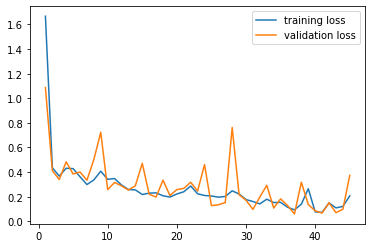

In [13]:
tl1=[]
vl1=[]
a=[]
for i in tl:
    tl1.append(float(i))
for i in vl:
    vl1.append(float(i))
for i in range(1,46):
    a.append(i)
plt.plot(a,tl1,label='training loss')
plt.plot(a,vl1,label='validation loss')
plt.legend()

92.0

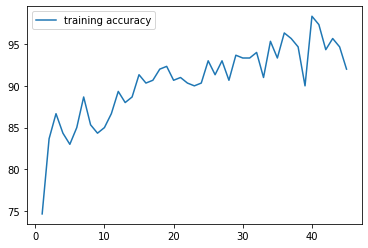

In [14]:
ta1=[]
for i in ta:
    ta1.append(float(i))
plt.plot(a,ta1,label='training accuracy')
plt.legend()
ta1[-1]

In [15]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [16]:
testa,testl=[],[]
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target) 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
        print('Test Loss: {:.6f}\n'.format(test_loss))
        testl.append(float(test_loss))

        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))
        testa.append(100. * correct / total)
        print('')

In [17]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.030750


Test Accuracy: 100% ( 8/ 8)

Test Loss: 0.251103


Test Accuracy: 93% (15/16)

Test Loss: 0.190336


Test Accuracy: 95% (23/24)

Test Loss: 0.234427


Test Accuracy: 93% (30/32)

Test Loss: 0.244907


Test Accuracy: 92% (37/40)

Test Loss: 0.205636


Test Accuracy: 93% (45/48)

Test Loss: 0.210938


Test Accuracy: 92% (52/56)

Test Loss: 0.215479


Test Accuracy: 92% (59/64)

Test Loss: 0.204091


Test Accuracy: 93% (67/72)

Test Loss: 0.187153


Test Accuracy: 93% (75/80)

Test Loss: 0.201939


Test Accuracy: 92% (81/88)

Test Loss: 0.205574


Test Accuracy: 91% (88/96)

Test Loss: 0.210296


Test Accuracy: 91% (91/100)



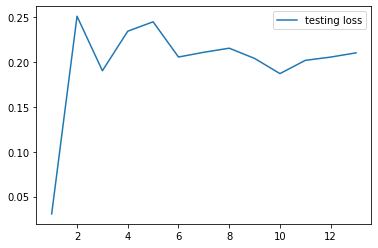

In [18]:
testl1=[]
a=[]
for i in testl:
    testl1.append(float(i))
for i in range(len(testl1)):
    a.append(i+1)
plt.plot(a,testl1,label='testing loss')
plt.legend()

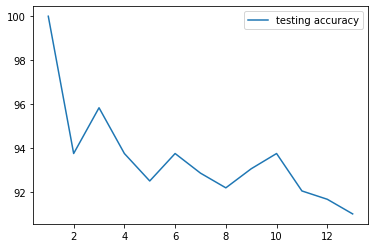

In [19]:
testa1=[]
for i in testa:
    testa1.append(float(i))
plt.plot(a,testa1,label='testing accuracy')
plt.legend()